# Kaggle Pneumonia XRay Test

In [1]:
RUN_NAME = '20210106 - Pneum XRay - multiplier experiment few _b'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set sensible default parameters for matplotlib
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

plt.style.use('dark_background')

In [2]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
import fastai
from fastai.callback.wandb import *

%env WANDB_WATCH=false
import wandb
wandb.login()
wandb.init(project='Kaggle Pneumonia XRay')
wandb.run.name = RUN_NAME

plt.style.use('classic')

mean = np.zeros((1,))
std = np.zeros((1,))


wandb: Currently logged in as: cogsci2 (use `wandb login --relogin` to force relogin)


env: WANDB_WATCH=false


<br>
<br>

## Check for an available GPU

In [3]:
import torch
print('CUDA available: '.ljust(25), torch.cuda.is_available())
print('CUDA device count: '.ljust(25), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device num: '.ljust(25), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(25), torch.cuda.get_device_name(current_device))

CUDA available:           True
CUDA device count:        1
Current CUDA Device num:  0
Current CUDA Device:      GeForce RTX 2070 SUPER


In [4]:
path = './train'

<br>
<br>

## Check for Balance - the Number of Images in Each Class

In [5]:
viral_fnames = get_image_files(path + '/PVI')
bac_fnames = get_image_files(path + '/PBAC')
delta = len(bac_fnames) - len(viral_fnames)
print('len(bac_fnames)     : ', len(bac_fnames))
print('len(viral_fnames)   : ', len(viral_fnames))
print()
print('delta               : ', delta)


len(bac_fnames)     :  2780
len(viral_fnames)   :  1493

delta               :  1287


<br>

#### Rebalance the Dataset by Oversampling the Virus Data

(See <a href="https://arxiv.org/abs/1710.05381">A systematic study of the class imbalance problem in convolutional neural networks by Buda, et al</a> for why oversampling is often the best method for correcting imbalance issues.)

In [6]:
vi_df = pd.DataFrame(list(viral_fnames))
additional_vi = vi_df.sample(delta)
vi_df = vi_df.append(additional_vi)
upsampled_viral_fnames = L(list(vi_df.values.reshape(len(vi_df),)))


#### Ensure it's Balanced

In [7]:
print('len(upsampled_viral_fnames): ', len(upsampled_viral_fnames))
print('len(bac_fnames):             ', len(bac_fnames))

len(upsampled_viral_fnames):  2780
len(bac_fnames):              2780


<br>


#### Combine the Output Variables into a Single DF

In [8]:
fnames = upsampled_viral_fnames + bac_fnames  # combine the categories
fnames = pd.DataFrame(list(fnames)).sample(len(fnames)).reset_index(drop=True)  # shuffle
print('len(fnames): ', len(fnames))

len(fnames):  5560


<br>
<br>

### Split into Training and Testing sets

In [9]:
test_df = fnames.sample( int(0.2 * len(fnames)) )  # Test set
train_df = fnames.drop(test_df.index)  # Train set 

test_set = L(list(test_df.values.reshape(-1,)))
train_set = (list(train_df.values.reshape(-1,)))

# experiment multiplier
train_set = (train_set + train_set + train_set)

print('len(test_set):   ', len(test_set))
print('len(train_set):   ', len(train_set))

len(test_set):    1112
len(train_set):    13344


In [10]:
# empty
def get_train_fnames(path):

    return train_set 


<br>

### Create the DataBlock with Image Augmentations

In [11]:
# tfms = setup_aug_tfms([Normalize.from_stats(mean, std)])
tfms = aug_transforms(size=300, do_flip=False, batch=True, max_zoom=1.0)

In [12]:
imgs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_train_fnames, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label, 
    item_tfms=Resize(300, method='bilinear')) #,
#     batch_tfms=tfms)
    
    
#     batch_tfms=Normalize.from_stats(mean=0.5, std=0.1))    
#     batch_tfms=Normalize.from_stats(*imagenet_stats))

In [13]:
# imgs.normalize()

<br>

## Resize and add basic image augmentation

In [14]:
# signs = signs.new(item_tfms=Resize(128, method=ResizeMethod.Squish), 
#                   batch_tfms=aug_transforms(mult=1.4, max_zoom=1))
# imgs = imgs.new(item_tfms=Resize(160, method=ResizeMethod.Squish))

# signs.apply_tfms(Image.flip)
# imgs.apply_tfms(Normalize.from_stats(*imagenet_stats))
# imgs.transform(Normalize.from_stats(*imagenet_stats))

<br>

### Load the data by path

In [15]:
dls = imgs.dataloaders(path, batch_size=32)

In [16]:
# means = [xb.mean(dim=(0, 2, 3)) for xb, yb in dls.train]
# stds = [xb.std(dim=(0, 2, 3)) for xb, yb in dls.train]
# mean, std = torch.stack(means).mean(dim=0), torch.stack(stds).mean(dim=0)
# print(mean, std)

<br>

### Verify the Training and Validation Batches

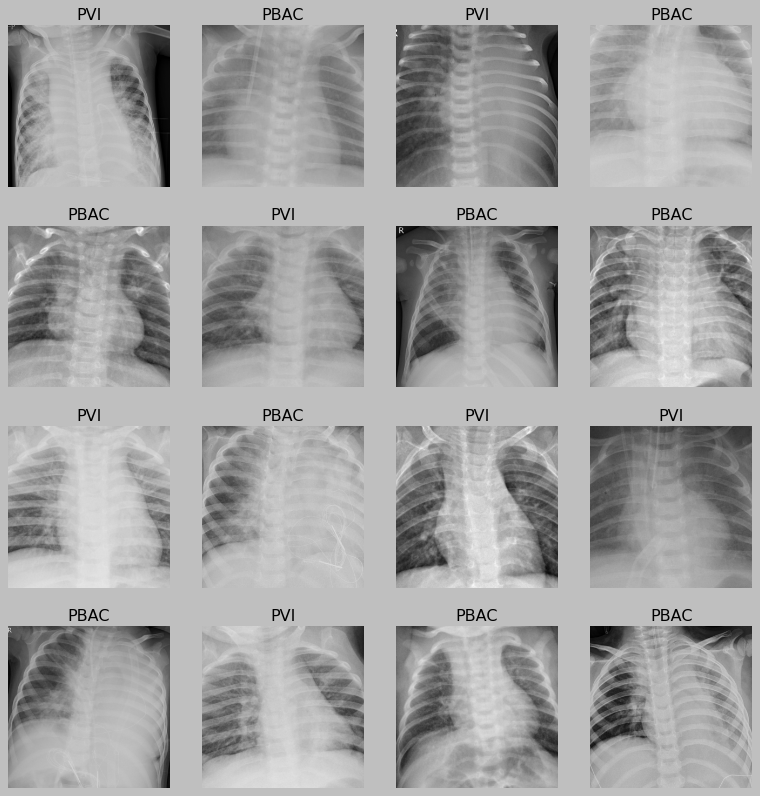

In [17]:
dls.valid.show_batch(max_n=16, nrows=4)

<br>

### Define the model (Resnet50) and fit

In [18]:
learn = cnn_learner(dls, resnet50 , pretrained=True, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()])

## @TODO try xresnet50_deeper pretrained true

<br>
<br>

#### Look at the Loss function

In [19]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

#### Look at the Optimization Function

In [20]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

### Look at the Model Architecture

In [21]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

<br>
<br>

### Define an Early Stopping and WandB Callbacks

In [22]:
early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0001, patience=3)
wandbcb = WandbCallback(log='all')

<br>
<br>

## Find an Appropriate Learning Rate

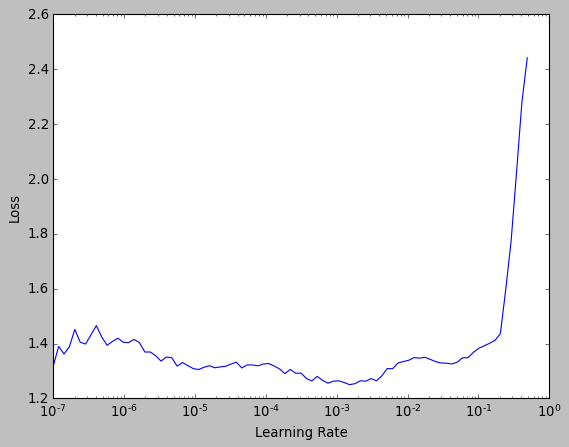

In [23]:
lr_min,lr_steep = learn.lr_find(end_lr=4) 
# Recorder.plot_lr_find()

In [24]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.52e-04, steepest point: 1.65e-06


<br>
<br>

## Fit the Model

Unfreeze the model after 3 epochs to train on entire net.

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.025654,0.672690,0.303273,0.696727,0.701426,0.687560,0.715863,02:30
1,0.892168,0.631640,0.265801,0.734199,0.739471,0.721797,0.758032,02:30
2,0.832446,0.564573,0.229328,0.770672,0.770958,0.766369,0.775602,02:30
3,0.704208,0.522688,0.217087,0.782913,0.783777,0.777010,0.790663,02:30
4,0.691442,0.496509,0.194604,0.805396,0.810876,0.785143,0.838353,02:30
5,0.632212,0.420022,0.176368,0.823632,0.819437,0.835245,0.804217,02:30
6,0.577936,0.414975,0.180615,0.819385,0.828388,0.785682,0.876004,02:31


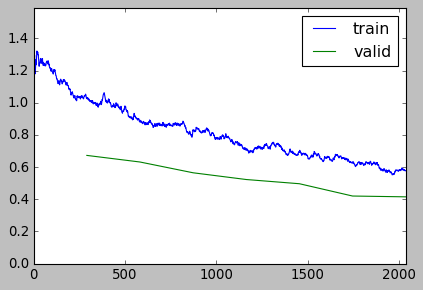

Better model found at epoch 0 with valid_loss value: 0.6726903319358826.
Better model found at epoch 1 with valid_loss value: 0.631639838218689.
Better model found at epoch 2 with valid_loss value: 0.5645734667778015.
Better model found at epoch 3 with valid_loss value: 0.5226883888244629.
Better model found at epoch 4 with valid_loss value: 0.49650901556015015.
Better model found at epoch 5 with valid_loss value: 0.42002159357070923.
Better model found at epoch 6 with valid_loss value: 0.41497477889060974.


wandb: Adding directory to artifact (/tmp/tmpvao7alan)... Done. 0.2s


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.502753,0.369092,0.155134,0.844866,0.849891,0.819580,0.882530,03:18
1,0.477150,0.336033,0.136648,0.863352,0.868982,0.830967,0.910643,03:18
2,0.401365,0.286435,0.107669,0.892331,0.894285,0.874341,0.915161,03:18
3,0.360866,0.245981,0.088434,0.911566,0.912159,0.901865,0.922691,03:16
4,0.285358,0.203851,0.074194,0.925806,0.927081,0.907256,0.947791,03:16
5,0.235263,0.157483,0.054459,0.945541,0.946226,0.930165,0.962851,03:17
6,0.192889,0.146697,0.052960,0.947040,0.948743,0.915112,0.984940,03:18
7,0.148704,0.098625,0.035224,0.964776,0.964812,0.959305,0.970382,03:16
8,0.115528,0.077728,0.024232,0.975768,0.975925,0.965145,0.986948,03:17
9,0.087198,0.065880,0.024731,0.975269,0.975094,0.977307,0.972892,03:16


Exception ignored in: <finalize object at 0x7f61e40a3640; dead>
Traceback (most recent call last):
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/tempfile.py", line 797, in _cleanup
    _shutil.rmtree(name)
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpvao7alan'


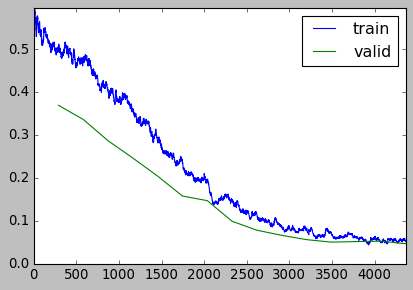

Better model found at epoch 0 with valid_loss value: 0.36909228563308716.
Better model found at epoch 1 with valid_loss value: 0.3360334038734436.
Better model found at epoch 2 with valid_loss value: 0.2864345908164978.
Better model found at epoch 3 with valid_loss value: 0.24598057568073273.
Better model found at epoch 4 with valid_loss value: 0.20385083556175232.
Better model found at epoch 5 with valid_loss value: 0.15748295187950134.
Better model found at epoch 6 with valid_loss value: 0.14669710397720337.
Better model found at epoch 7 with valid_loss value: 0.09862491488456726.
Better model found at epoch 8 with valid_loss value: 0.07772811502218246.
Better model found at epoch 9 with valid_loss value: 0.06587951630353928.
Better model found at epoch 10 with valid_loss value: 0.05578742176294327.
Better model found at epoch 11 with valid_loss value: 0.049992885440588.
Better model found at epoch 14 with valid_loss value: 0.046336617320775986.


wandb: Adding directory to artifact (/tmp/tmpj8s740ru)... Done. 0.2s


In [25]:
learn.fine_tune(15, base_lr=lr_min, freeze_epochs=7, cbs=[wandbcb, SaveModelCallback(), ShowGraphCallback()] )

In [26]:
# learn.fine_tune(100, base_lr=3e-4, cbs=[early_stop] )

In [27]:
# learn.unfreeze()


In [28]:
# learn.fit_one_cycle(5, cbs=[early_stop, wandbcb, SaveModelCallback()] )

<br>

### Plot Losses

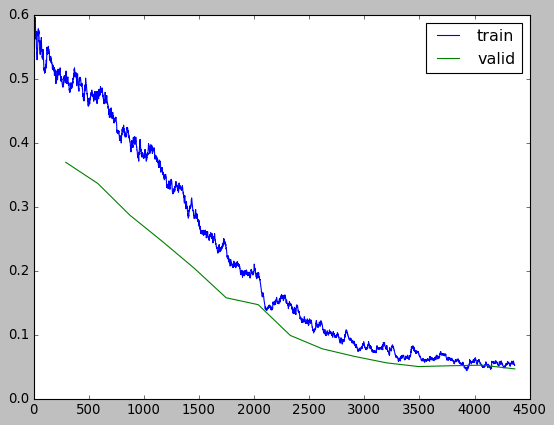

In [29]:
learn.recorder.plot_loss()

<br>

### Visualize with a confusion Matrix

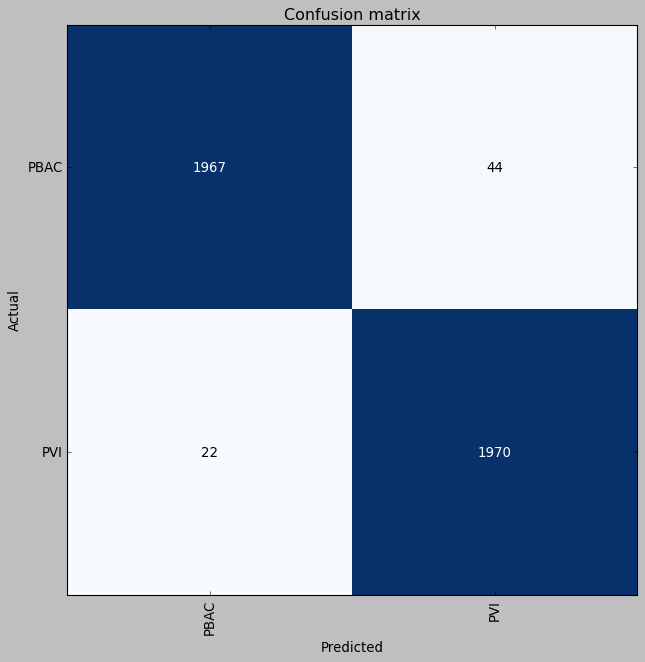

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [31]:
interp.print_classification_report()

              precision    recall  f1-score   support

        PBAC       0.99      0.98      0.98      2011
         PVI       0.98      0.99      0.98      1992

    accuracy                           0.98      4003
   macro avg       0.98      0.98      0.98      4003
weighted avg       0.98      0.98      0.98      4003



<br>

### Show the top 5 most error prone images

In [32]:
# interp.plot_top_losses(12, nrows=4)

In [33]:
# learn.predict('./val/NORMAL/NORMAL2-IM-1430-0001.jpeg')

In [34]:
learn.predict('./val/PNEUMONIA/person1946_bacteria_4874.jpeg')

('PBAC', tensor(0), tensor([9.9991e-01, 8.5664e-05]))

<br>
<br>

---

<br>
<br>

## Persist the Model

<br>
<br>

In [35]:
# wandb.save('./models/210103.h5')

In [36]:
learn.export(f'models/{RUN_NAME}.pkl')
path = Path('models')
path.ls(file_exts='.pkl')

(#8) [Path('models/20210106 - Pneum XRay - multiplier experiment few.pkl'),Path('models/20200103.pkl'),Path('models/20210106 - Pneum XRay - multiplier experiment few _b.pkl'),Path('models/20210106 - Pneum XRay - xresnet50deep.pkl'),Path('models/20210104 - Pneum XRay Reboot b.pkl'),Path('models/20210106 - Pneum XRay.pkl'),Path('models/20210103a.pkl'),Path('models/20210106 - Pneum XRay - multiplier experiment.pkl')]

<br>
<br>

## Close WandB Process and Report

In [37]:
wandb.join()

epoch,22
train_loss,0.05195
raw_loss,0.00839
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▅█▇▄▄▄▆▅▄▄▂▄▃▄▂▃▂▃▂▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▂▃▄▅▅▆▇███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,██▇▇▆▅▄▄▃▂▂▁▁█▇▆▅▃▃▁▁▁▁▁▂▂▃▃▄▄▅▅▆▆▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▃▄▅▅▆▇███▂▂▂▃▄▄▄▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁


In [38]:
wandb.finish()

<br>
<br>

## Test Set Validation

In [39]:
def get_test_fnames(path):
    return test_set

In [40]:
test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label, 
    item_tfms=Resize(300, method='bilinear')) #,

test_dl = dls.test_dl(test_set, with_labels=True)

<br>
<br>

####  Get the Inferrences on the Test Set

In [41]:
test_preds = learn.get_preds(0, dl=test_dl)[0]

In [42]:
len(test_preds)

1112

<br>
<br>

### Predict over the Entire Test Set

In [43]:
print('\nImage File'.ljust(40), 'Predicted Category\n')

f_cnt, t_cnt = 0, 0

for i, p in enumerate(test_preds):
    if p[0] > p[1]:
        cat = 'BACTERIAL'
        
        if '_bacteria_' in str(test_set[i]): t_cnt = t_cnt + 1
        else: f_cnt = f_cnt + 1
            
    else:
        cat = 'VIRAL'
        
        if '_virus_' in str(test_set[i]): t_cnt = t_cnt + 1
        else: f_cnt = f_cnt + 1
            
            
    print(str(test_set[i]).split('/')[-1].ljust(40), cat)
    



Image File                              Predicted Category

person745_virus_1368.jpeg                VIRAL
person113_bacteria_540.jpeg              BACTERIAL
person626_virus_1202.jpeg                BACTERIAL
person1470_bacteria_3830.jpeg            BACTERIAL
person1230_virus_2081.jpeg               VIRAL
person92_virus_174.jpeg                  BACTERIAL
person357_bacteria_1640.jpeg             BACTERIAL
person1506_virus_2616.jpeg               VIRAL
person269_virus_554.jpeg                 VIRAL
person119_virus_225.jpeg                 VIRAL
person570_virus_1112.jpeg                VIRAL
person141_bacteria_681.jpeg              BACTERIAL
person1325_bacteria_3366.jpeg            VIRAL
person122_virus_229.jpeg                 VIRAL
person124_virus_242.jpeg                 VIRAL
person744_virus_1367.jpeg                VIRAL
person992_bacteria_2919.jpeg             BACTERIAL
person99_bacteria_473.jpeg               BACTERIAL
person493_bacteria_2086.jpeg             BACTERIAL
person1916

In [44]:
print()
print(f'Correct inferences:    {t_cnt} --> {100 * t_cnt/len(test_preds)}')
print(f'Incorrect inferences:  {f_cnt} --> {100 * f_cnt/len(test_preds)}')


Correct inferences:    963 --> 86.60071942446044
Incorrect inferences:  149 --> 13.399280575539569
